# Modelling seismically isolated vacuum chamber "VATIGrav" 

Authors: Artem Basalaev <artemDOTbasalaev@pmDOTme>,  Octavio Vega <vega00087@gmailDOTcom>

If not done already, install spicypy (**uncomment the line below**):

In [1]:
#pip install spicypy

Note: on Windows the above might not work, you may see a compilation error in `ligo-segments` package. If this happens, please install `gwpy` separately first, by running `conda install -c conda-forge gwpy` in your terminal. (It must be an Anaconda environment, unfortunately currently there's no easy way to install on Windows without Anaconda. We are working on that)

## Create model of the control system

VATIGrav chamber and corresponding schematic of the control system for active isolation:

![vatigrav.png](../_static/images/vatigrav_model/vatigrav.png)
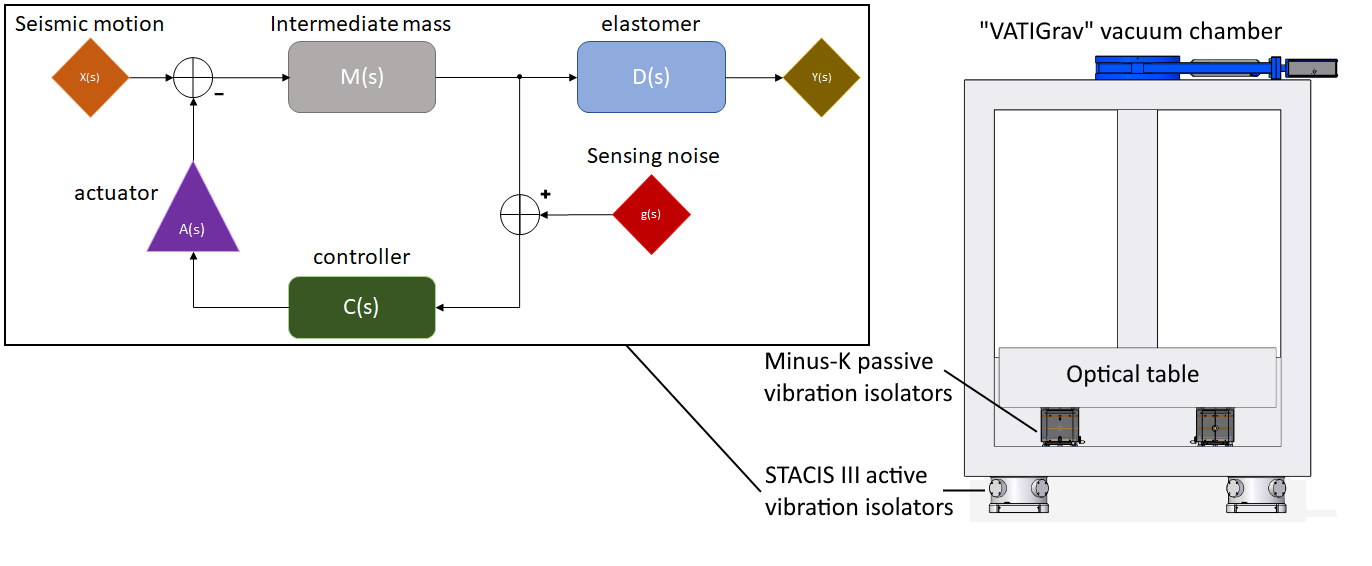

![vatigrav.png](vatigrav_model/vatigrav.png)

In [2]:
# frequency variable
from control import tf
s = tf('s')

# rubber elastomer
f0 = 20.0 # resonance frequency in HZ
import numpy as np
D = 1/(s**2 + 50*s + (2*np.pi*f0)**2)

# actuator
A = tf(1,1) # for now assuming TF=1, exact actuator is not crucial for system dynamics

# controller (assuming simple integrator, real controller used by STACIS is likely more sophisticated)
C = 10**-3/s

# intermediate mass
M = tf(1,1) # for now assuming TF=1, most likely resonant at much higher frequencies than relevant here

System 1 (feedback system taking in seismic motion)

In [3]:
# create a feedback loop
from spicypy.control.system import System
sys_plant = System(M)
sys_ctrl = System(C)*System(A)

sys1 = sys_plant.feedback(sys_ctrl)
sys1 = System(sys1*D)

System 2 (sensing noise open loop)

In [4]:
# create a series connection
olg = sys_ctrl*sys_plant
sys2 = System(olg)

## Examine closed-loop impulse and step response

In [5]:
# calculate step and delta responses for sys1
from control import step_response, impulse_response, ss2io
step_resp = step_response(ss2io(sys1))
delta_resp = impulse_response(ss2io(sys1))

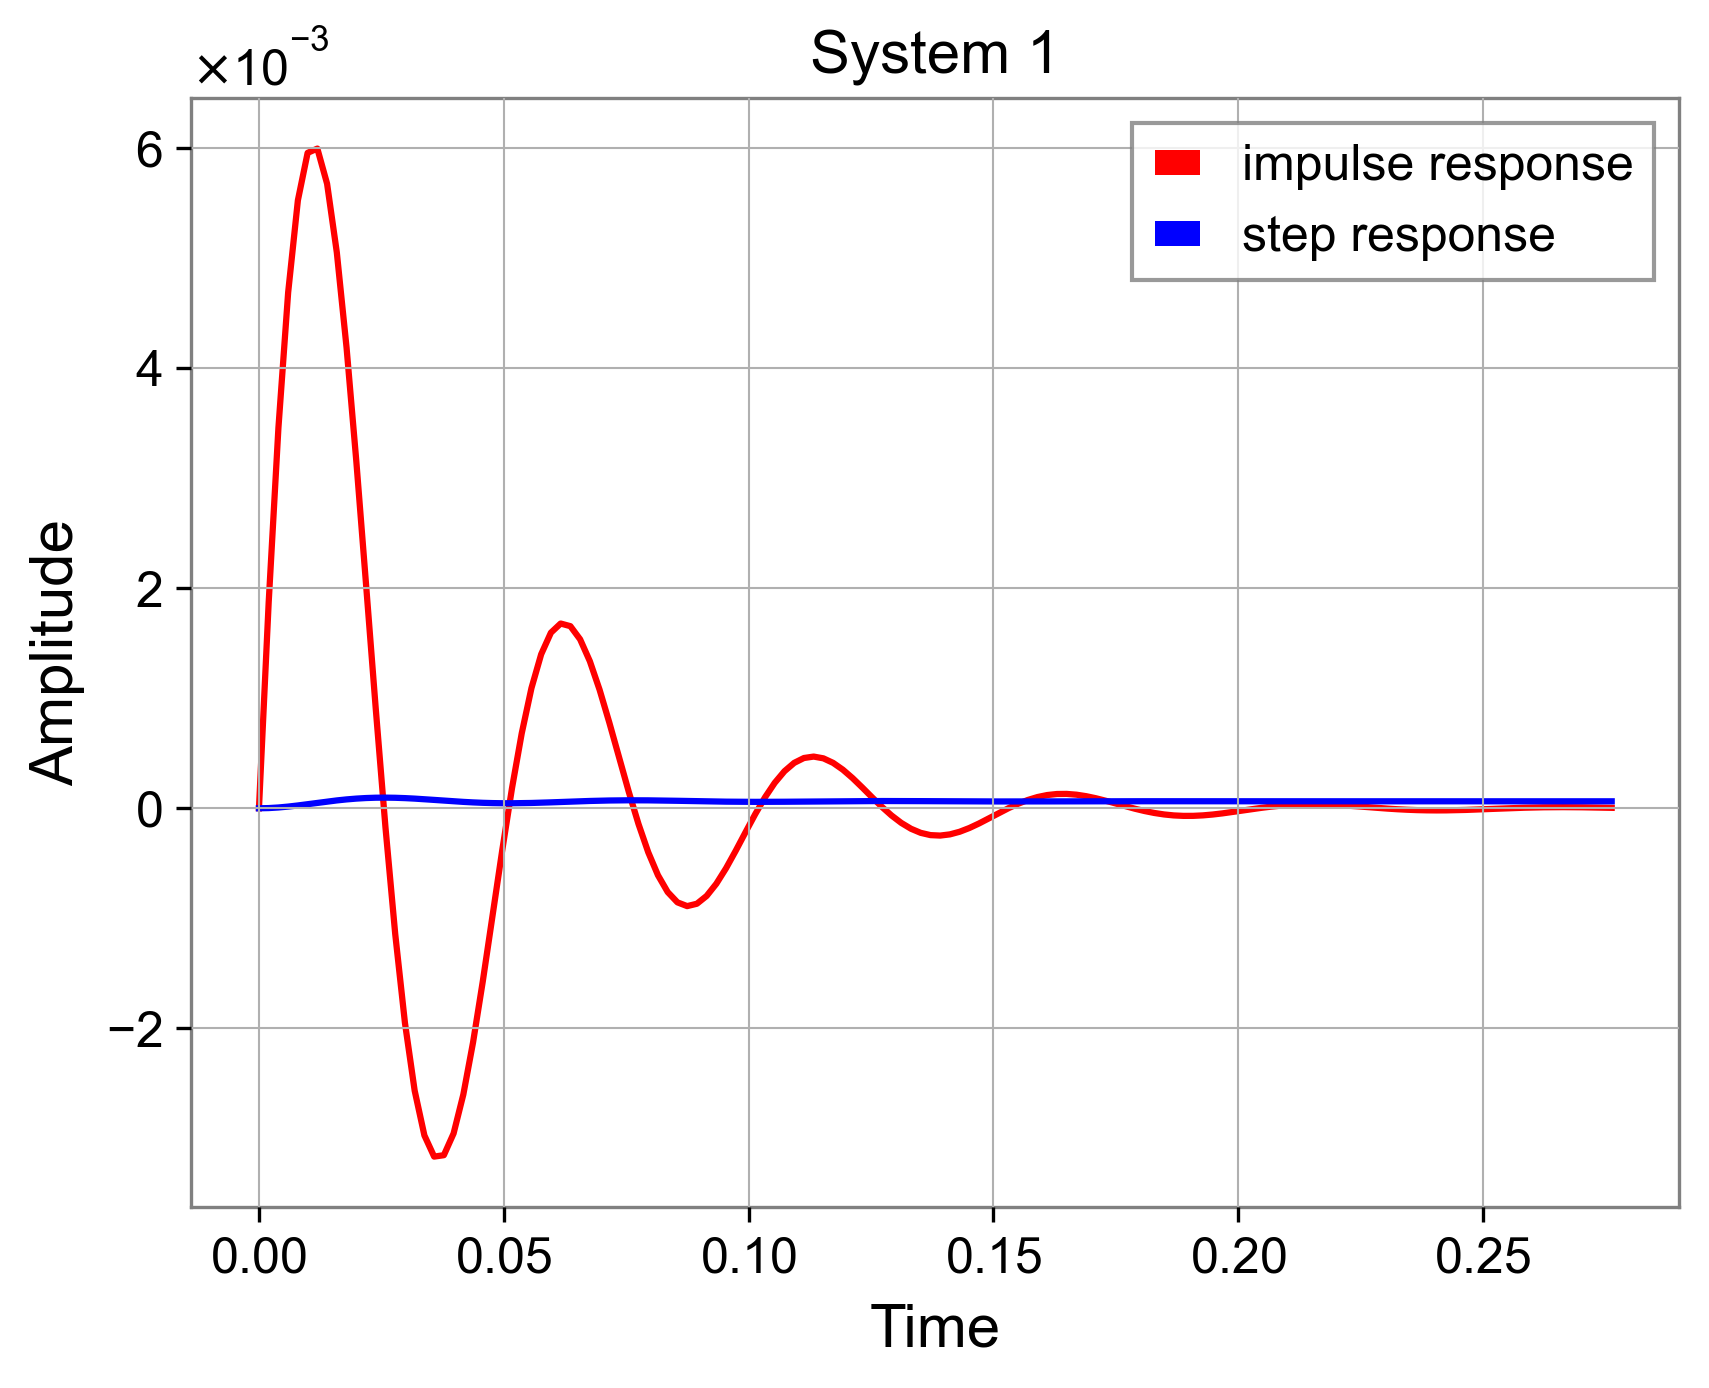

In [6]:
# plot step response and impulse responses
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.plot(delta_resp.time, delta_resp.outputs, color='red', label='impulse response')
plt.plot(step_resp.time, step_resp.outputs, color='blue', label='step response')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('System 1')
plt.legend()

## Feed seismic motion into System 1 and calculate response

Open data and visualize it

Text(0.5, 1.0, 'Input seismic motion')

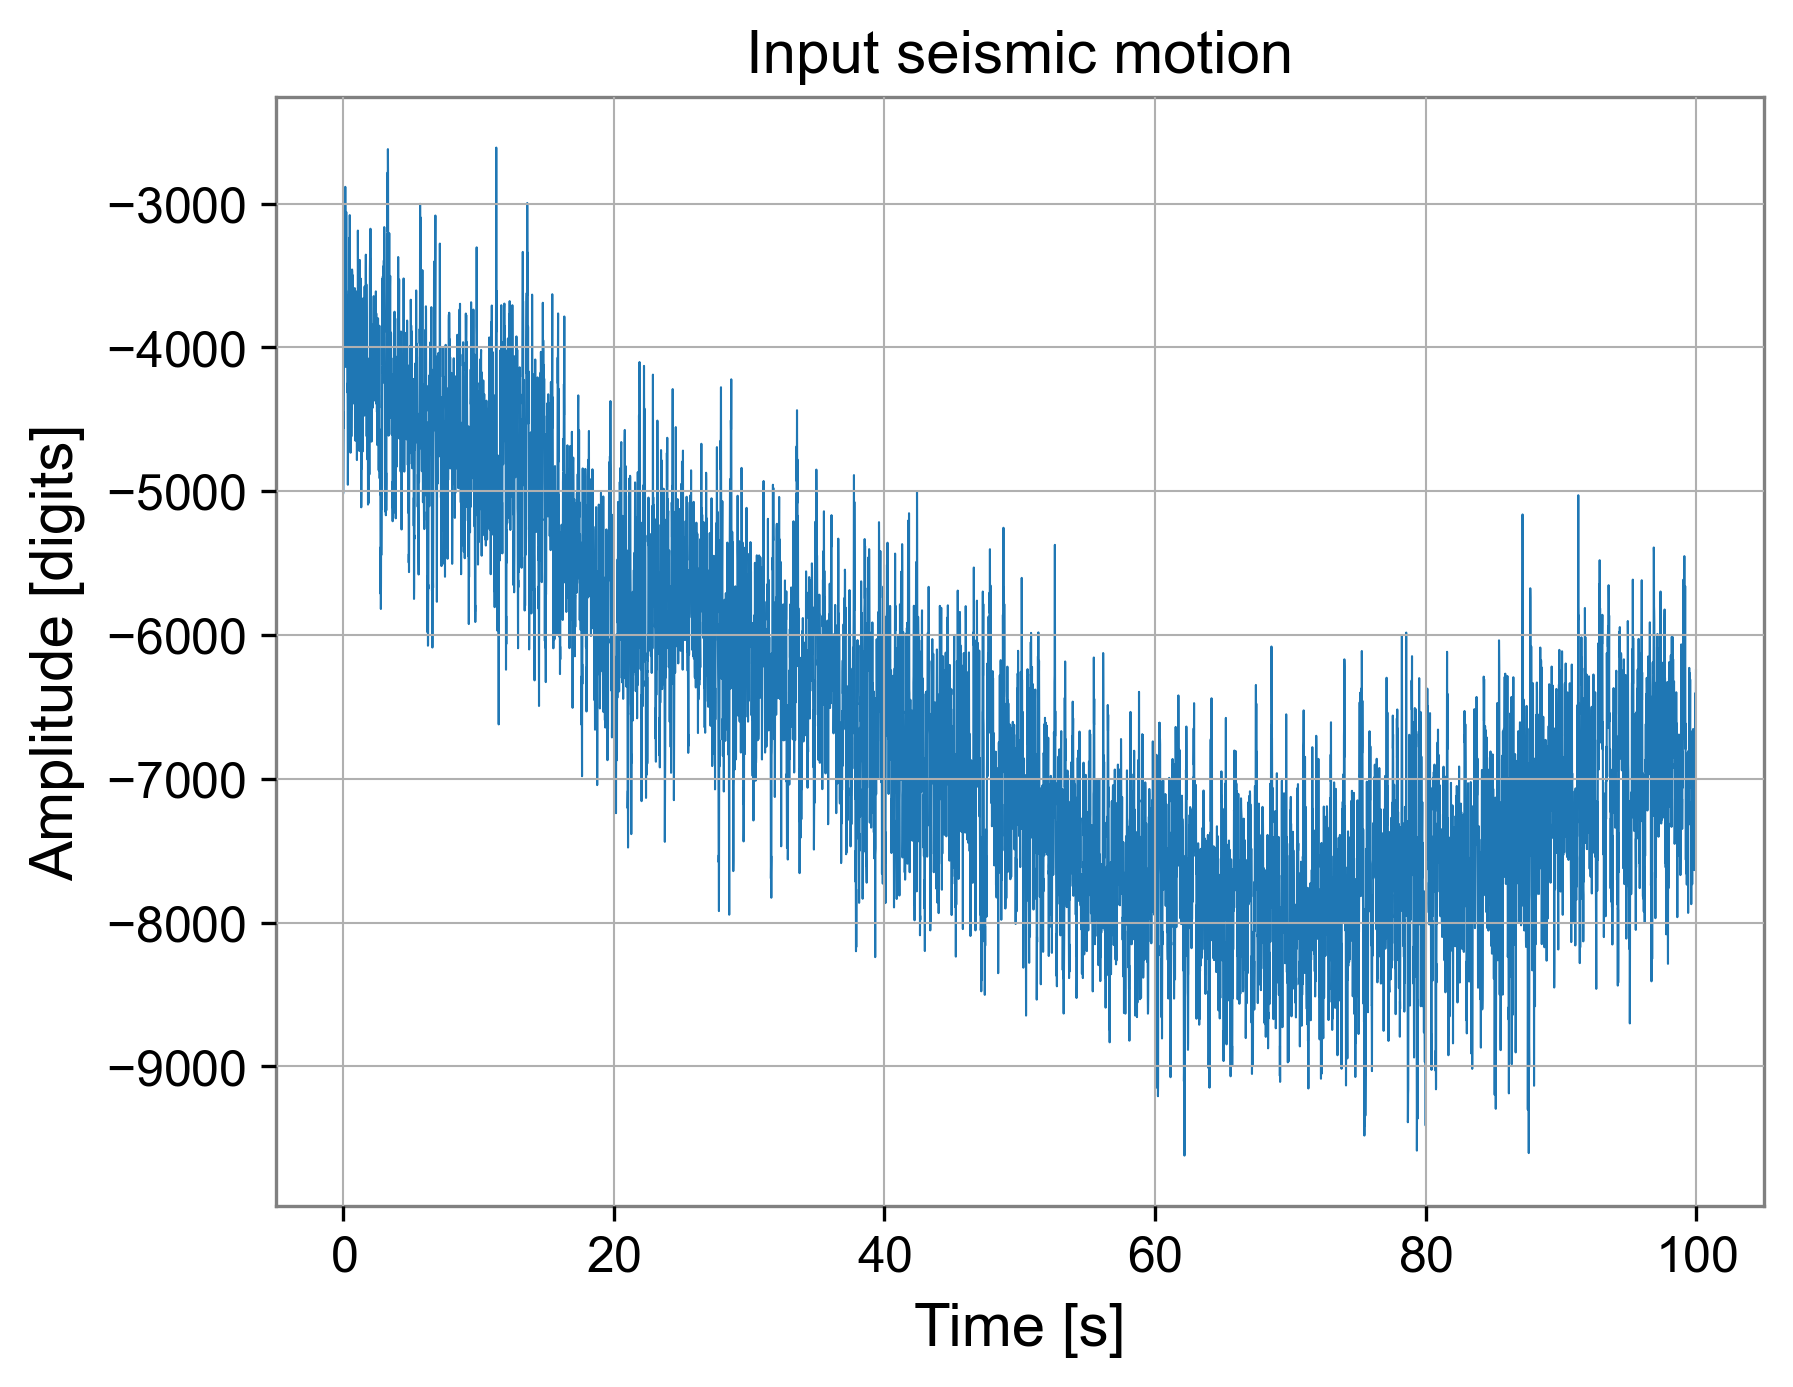

In [7]:
# open data
import pandas as pd
df_seismic = pd.read_csv('vatigrav_model/2022-05-20-13-44-59-1540000_5kHz_quiet_seis.csv')
s1x = df_seismic['S1X'] # seismometer 1, along X axis

# convert to time series with appropriate sample rate
from spicypy.signal.time_series import TimeSeries
input_seismic = TimeSeries(s1x[1500:], sample_rate=100) #removing first 1500 elements because we did "calibration jumps" in first few seconds
input_seismic = input_seismic[0:10000] # shortening input data, othervise response takes too long to run (but still possible if needed)

plt.plot(input_seismic, lw=0.5)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [digits]') # we have time series in digits, conversion to meters is done on the final spectrum with the instrument transfer function
plt.title('Input seismic motion')

Calculate response

Text(0.5, 1.0, 'Output seismic motion')

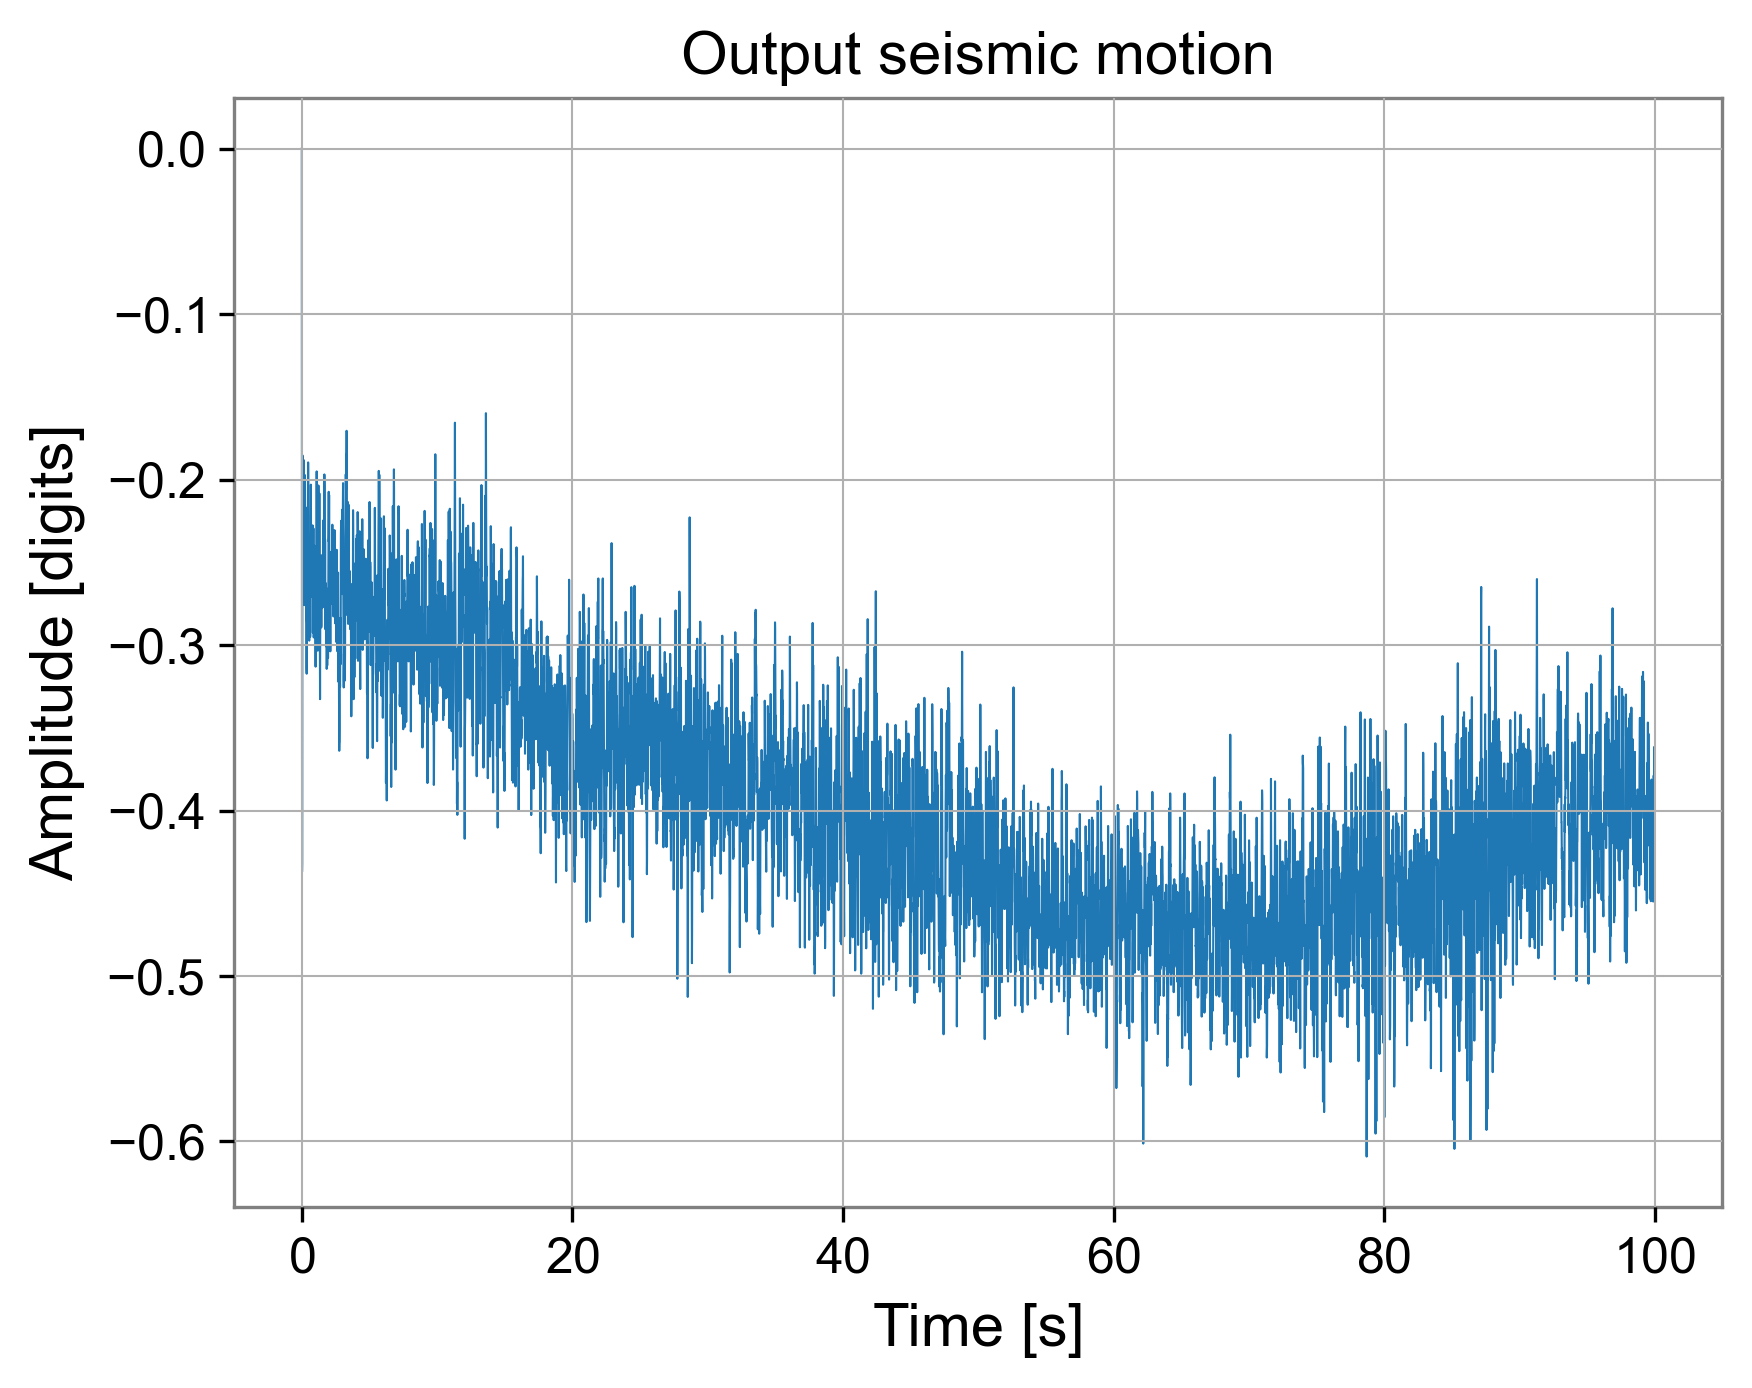

In [8]:
response_seismic = sys1.response(input_seismic)
plt.plot(response_seismic, lw=0.5)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [digits]') # we have time series in digits, conversion to meters is done on the final spectrum with the instrument transfer function
plt.title('Output seismic motion')

Calculate motion spectrum and plot it

Text(0, 0.5, 'Amplitude [digits]')

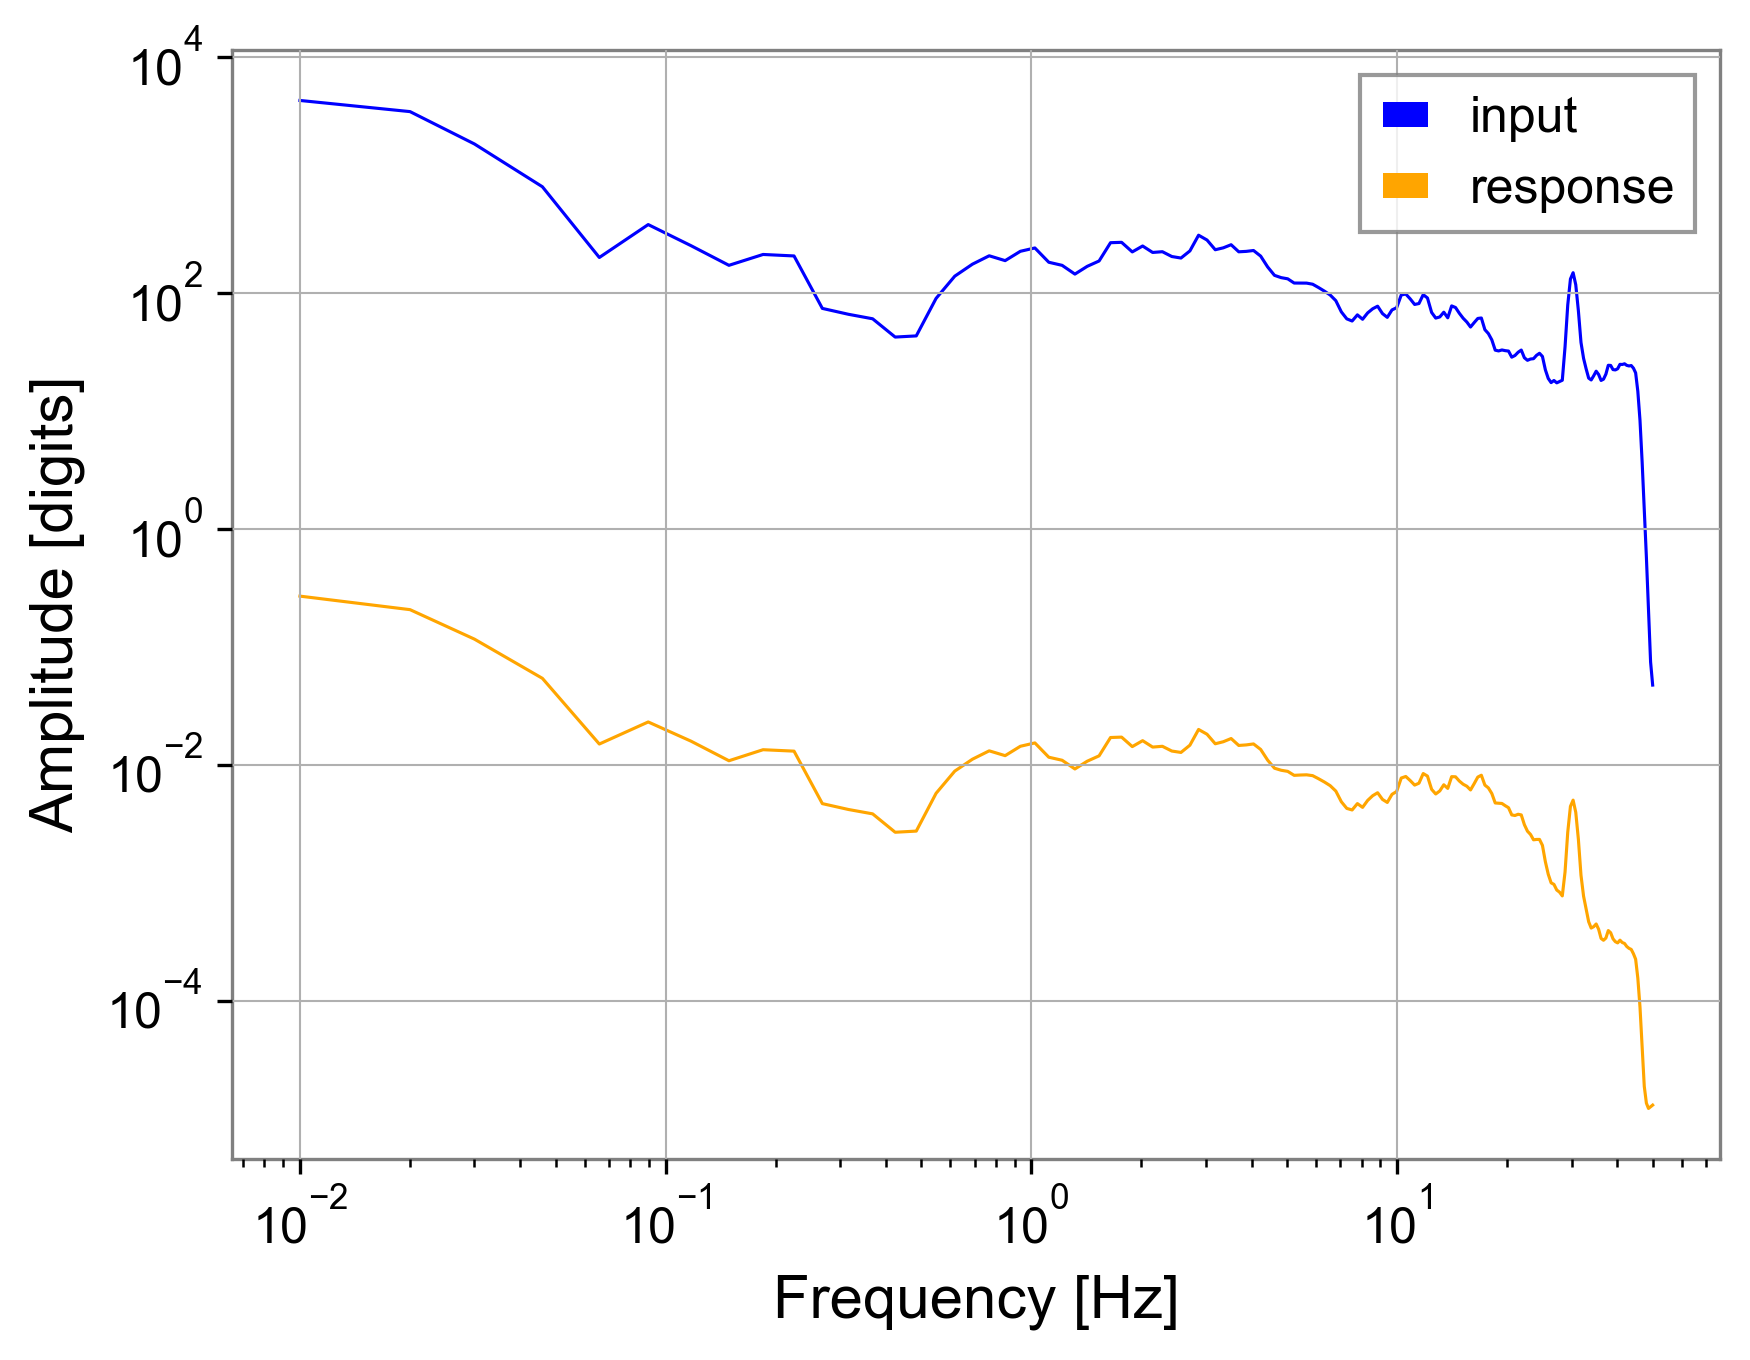

In [9]:
input_seismic_asd = input_seismic.asd(method="lpsd")
response_seismic_asd = response_seismic.asd(method="lpsd")

plt.loglog(input_seismic_asd, label='input', color='blue', lw=0.75)
plt.loglog(response_seismic_asd, label='response', color='orange', lw=0.75)
plt.legend()
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [digits]')

We see significant reduction already, but it's nicer to convert it to proper units

In [17]:
from spicypy.signal.frequency_series import FrequencySeries
from scipy.signal import zpk2tf, freqs

### Define function to remove instrument response and get data in physical units###
from astropy.units import Unit
def instrument_response(asd):
    ''' Conversion from velocity to displacement using TF from Trillium Horizon 120

        Args:
            asd (FrequencySeries): input ASD in digits
        
        Returns:
            asd (FrequencySeries): output ASD in m/s
    '''
    ### Pole-Zero representation of Trillium Horizon tranfer function ###
    poles =  [-0.036614 +0.037059j, -0.036614 -0.037059j, -32.55, -142, -364 +404j, -364 -404j, -1260, -4900 +5200j, -4900 -5200j, -7100 +1700j, -7100 -1700j]
    zeros =  [0, 0, -31.63, -160, -350, -3177]
    scale_factor = 1202.5 * 8.31871e17 * 400000         #V/(m/s) times gain times counts/V

    num_poly_coef, denom_poly_coef = zpk2tf(
        zeros, poles, scale_factor)

    omega = 2 * np.pi * asd.frequencies.value
    _, resp = freqs(num_poly_coef, denom_poly_coef, omega)
    respamp = np.sqrt(np.absolute(resp*np.conjugate(resp)))
    asd = asd/respamp
    asd.override_unit(Unit("m*s(-1)/Hz(1/2)"))
    return asd

Text(0, 0.5, 'Amplitude [m / $\\sqrt{\\mathrm{Hz}}$]')

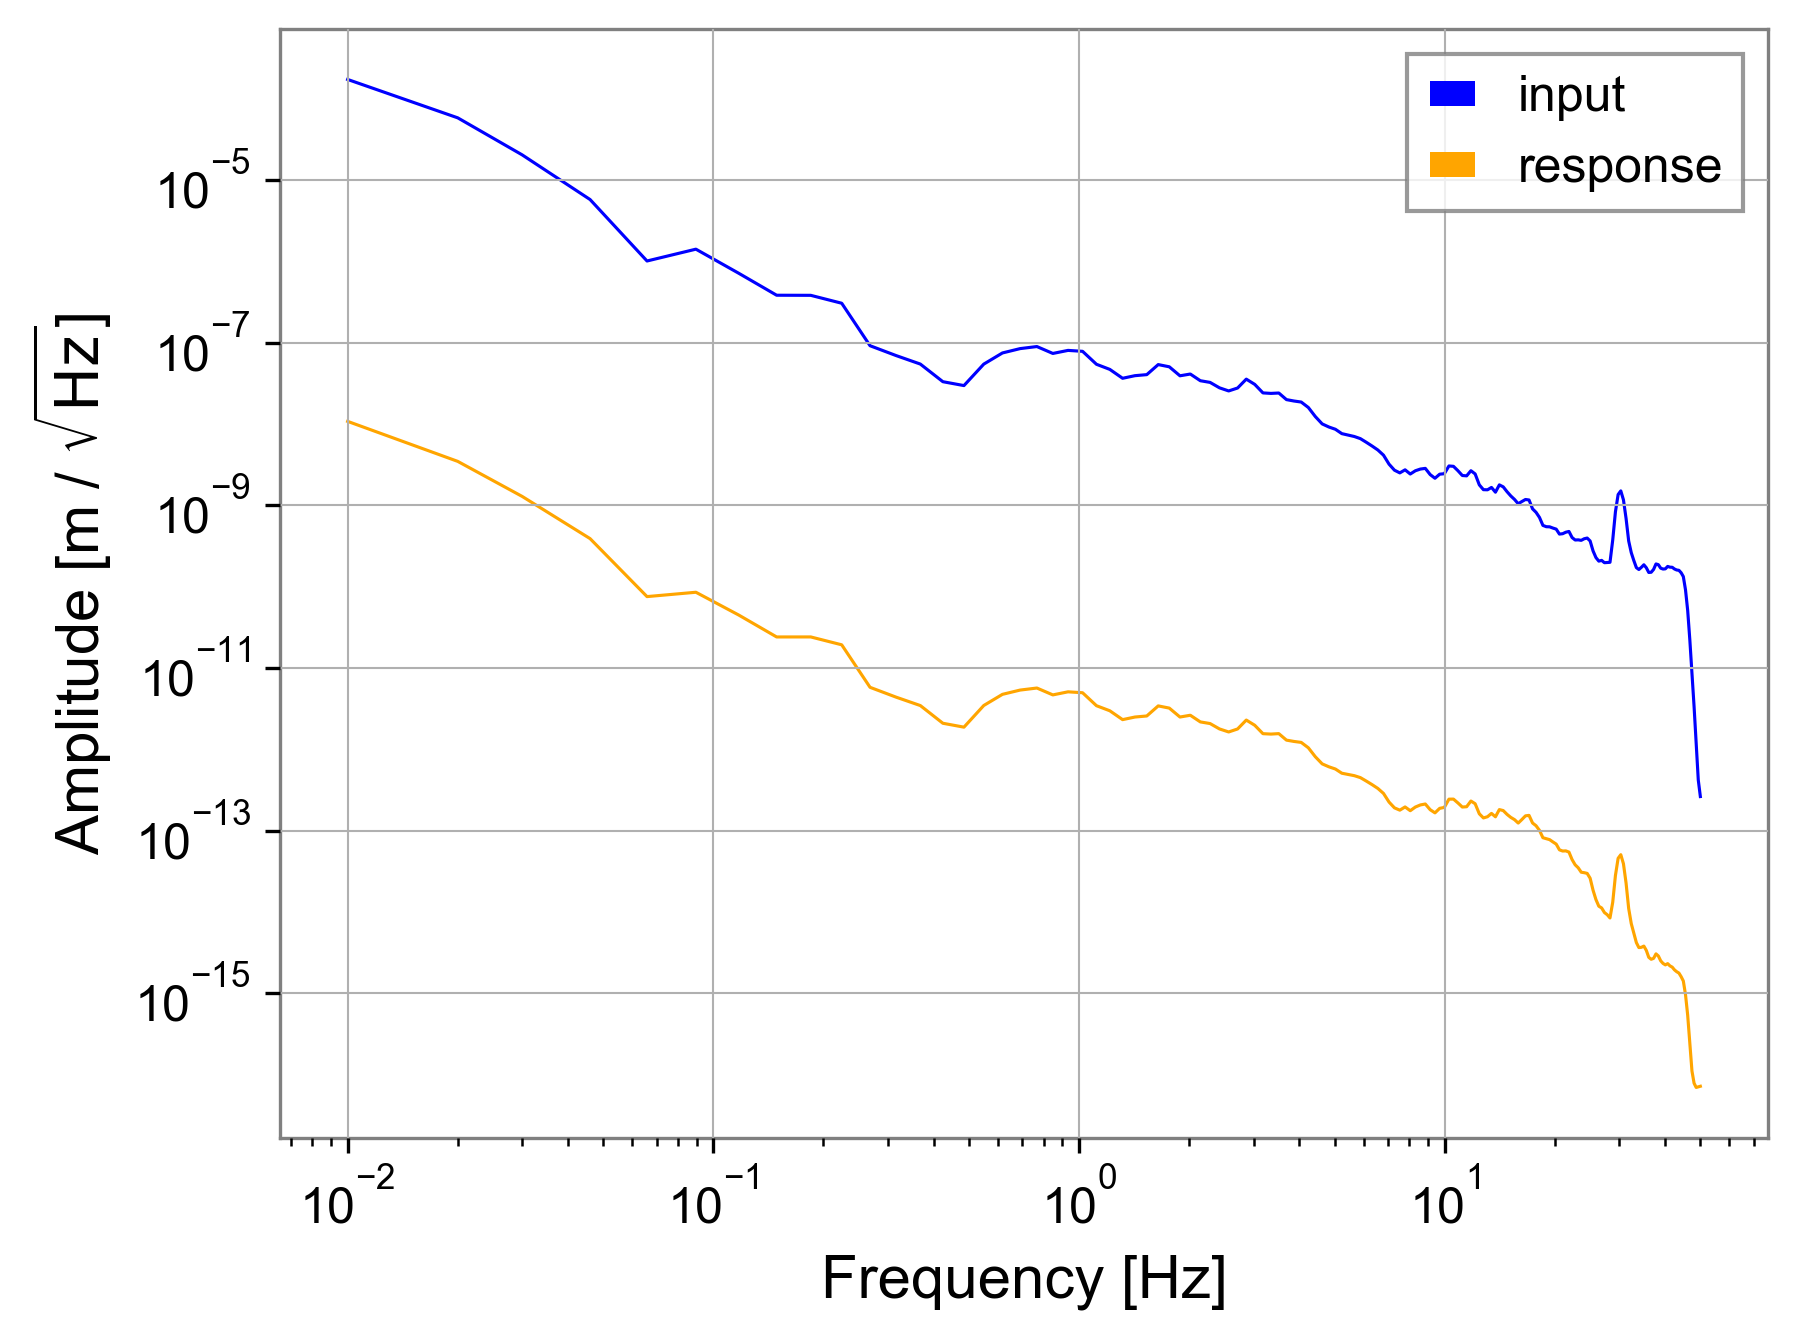

In [18]:
plt.loglog(instrument_response(input_seismic_asd).to_displacement(), label='input', color='blue', lw=0.75)
plt.loglog(instrument_response(response_seismic_asd).to_displacement(), label='response', color='orange', lw=0.75)
plt.legend()
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [m / $\sqrt{\mathrm{Hz}}$]')

## Feed sensor noise into System 2, calculate response and add it in quadrature

In that case our input data is already in the form of a spectrum (ASD). Open it and feed sthrough System 2

Text(0, 0.5, 'Amplitude [m / $\\sqrt{\\mathrm{Hz}}$]')

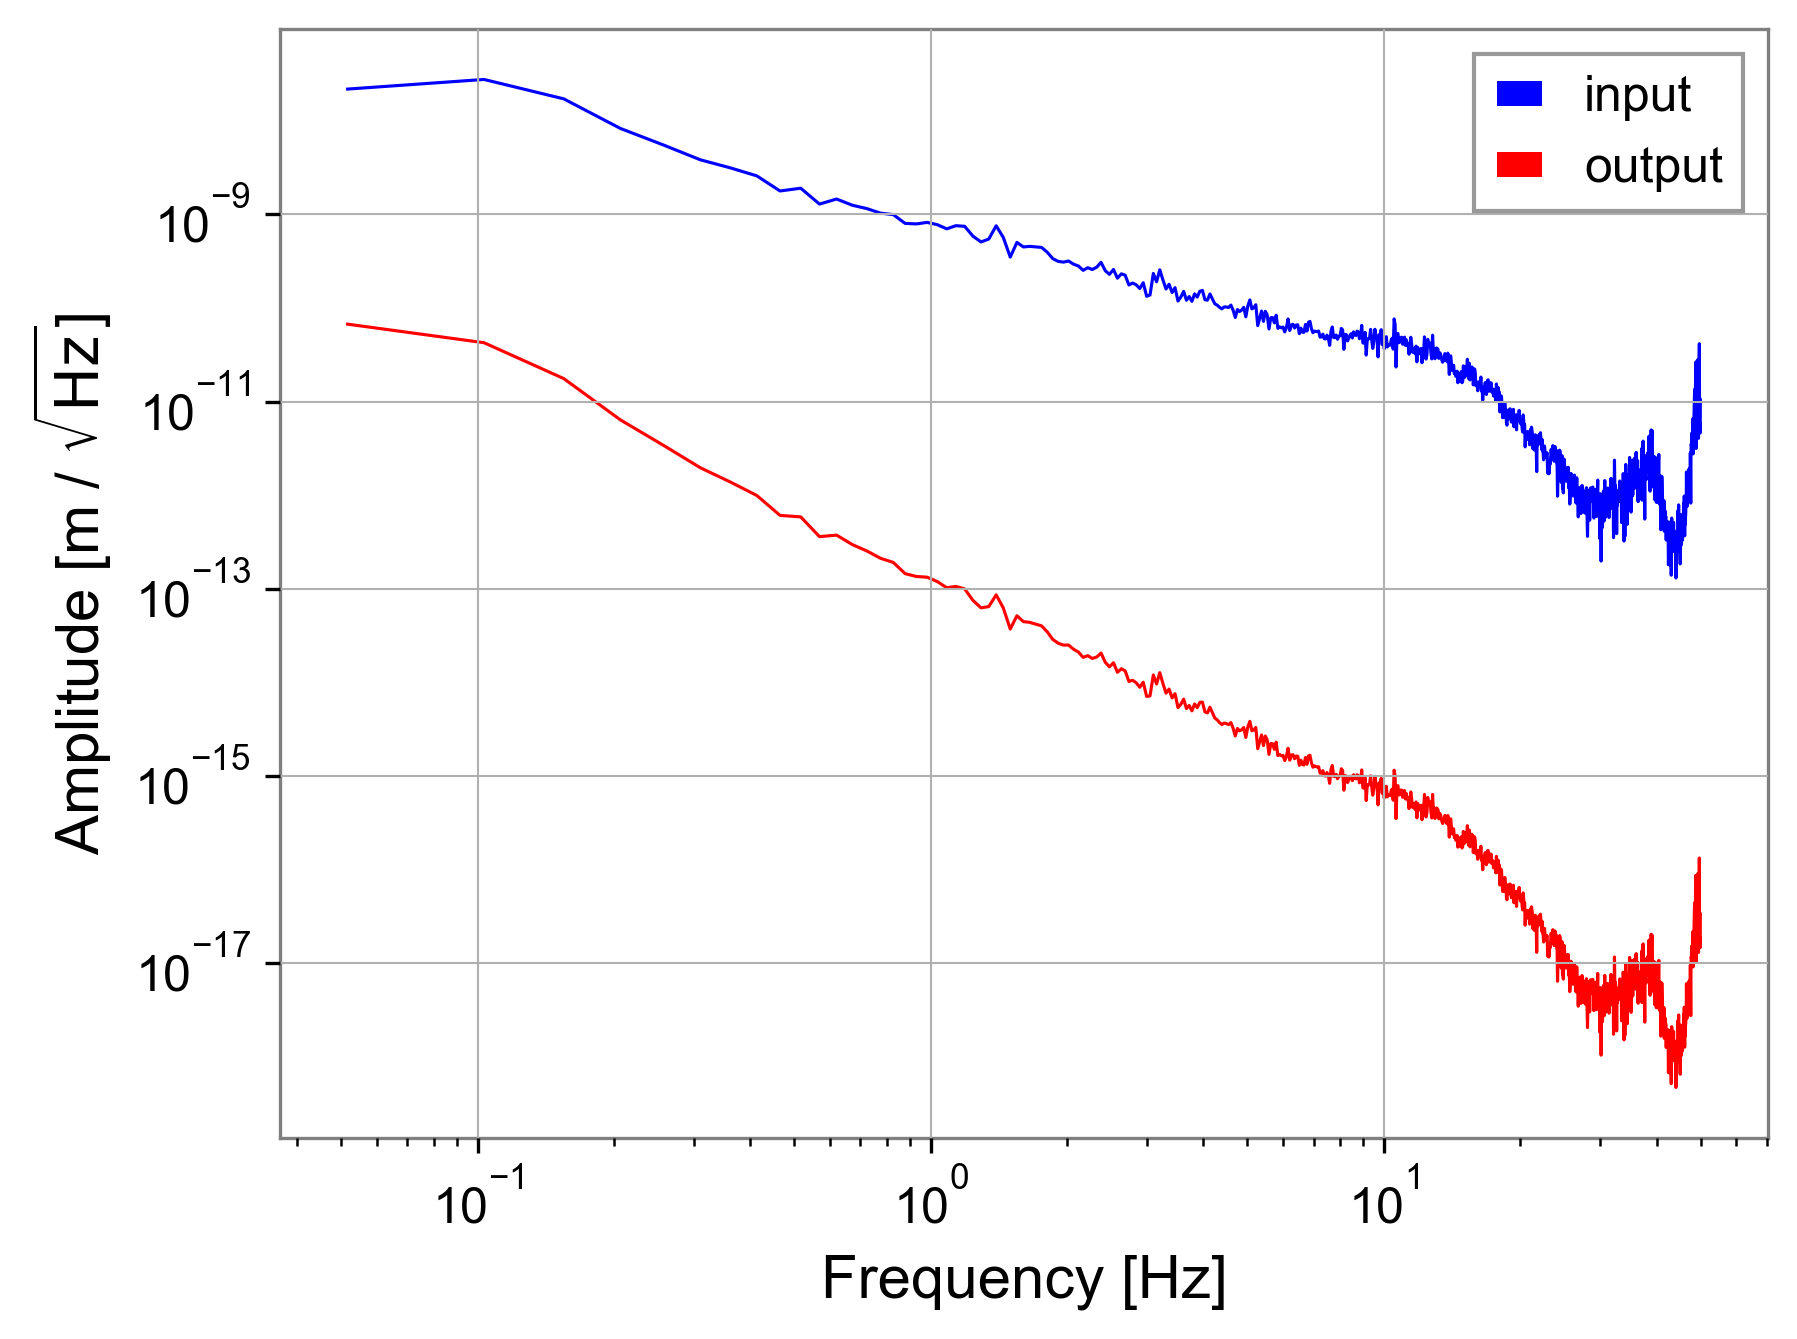

In [19]:
df_noise = pd.read_csv('vatigrav_model/Geo1X_self-noise.csv', header=None, index_col=0)
response_frequencies = df_noise.index.to_numpy()
response_mag,_,_ = sys2.frequency_response(2*np.pi*response_frequencies)
input_noise = df_noise[1].values 
output_noise = response_mag*df_noise[1].values 

plt.loglog(response_frequencies,input_noise, label='input', color='blue', lw=0.75)
plt.loglog(response_frequencies,output_noise, label='output', color='red', lw=0.75)
plt.legend()
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [m / $\sqrt{\mathrm{Hz}}$]')

Add noise in quadrature, and compare input seismic motion with output+sensor noise

Text(0, 0.5, 'Amplitude [m / $\\sqrt{\\mathrm{Hz}}$]')

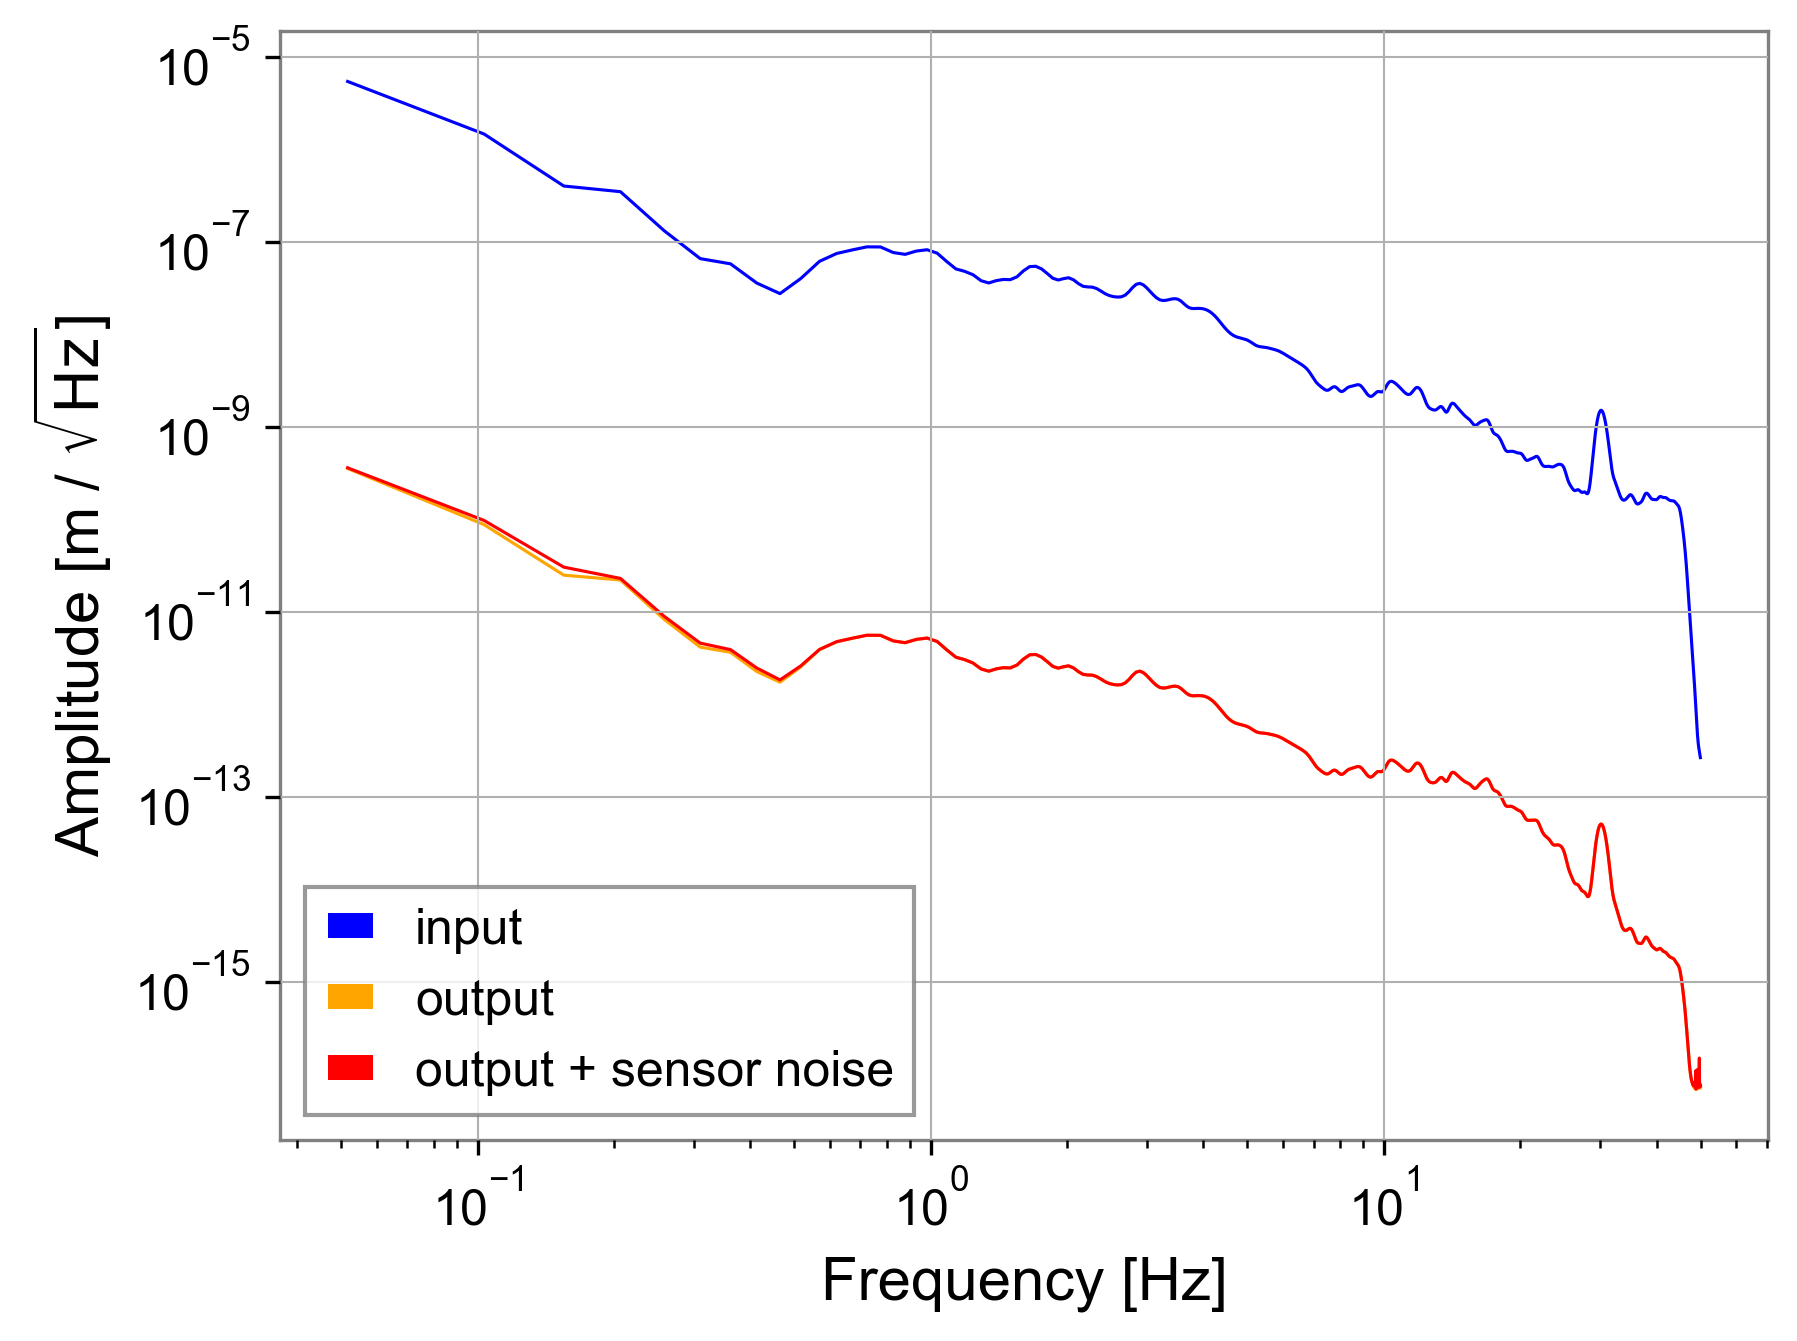

In [20]:
#first, interpolate seismic motion on a new (coarser) grid corresponding to sensor noise measurement
input_seismic = instrument_response(input_seismic_asd).to_displacement().value
output_seismic = instrument_response(response_seismic_asd).to_displacement().value
frequencies_seismic = response_seismic_asd.frequencies.value
#remove inf in first element
input_seismic[0] = 0
output_seismic[0] = 0
from scipy import interpolate
input_seismic_curve = interpolate.interp1d(frequencies_seismic, input_seismic, kind="cubic")
input_seismic_interp = input_seismic_curve(response_frequencies)
output_seismic_curve = interpolate.interp1d(frequencies_seismic, output_seismic, kind="cubic")
output_seismic_interp = output_seismic_curve(response_frequencies)

#now add noise in quadrature
output_seismic_interp_with_noise = np.sqrt(np.power(output_noise,2) + np.power(output_seismic_interp,2))
# and plot
plt.loglog(response_frequencies,input_seismic_interp, label='input', color='blue', lw=0.75)
plt.loglog(response_frequencies,output_seismic_interp, label='output', color='orange', lw=0.75)
plt.loglog(response_frequencies,output_seismic_interp_with_noise, label='output + sensor noise', color='red', lw=0.75)
plt.legend()
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [m / $\sqrt{\mathrm{Hz}}$]')

Result: with this control system, addition of sensor noise is barely percievable on the final plot. It should be noted that in this model, parameters of the controller are idealized and it remains to be seen if anything close to this can be achieved in a real system